# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [ ]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

## Load image

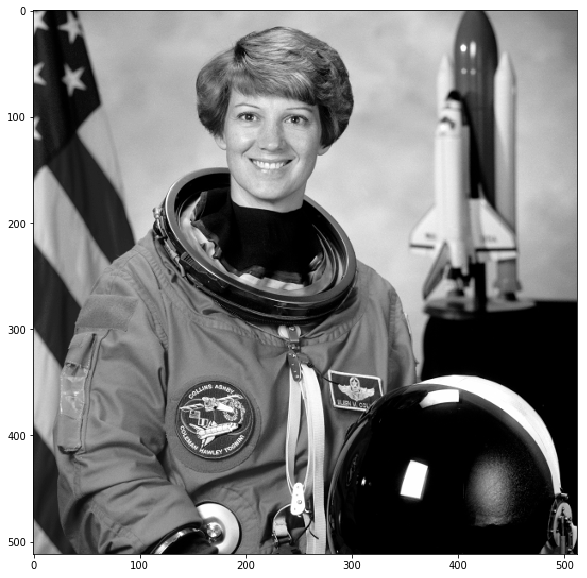

In [2]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]
m = n

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [64]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity

# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.

J = diags(diagonals=[
    [-1.0] * n,
    [1.0] * (n-1)
], offsets=[0, 1])

I = identity(n=n)

# Forward Horizontal Difference
D_h = kron(J, I)

# Forward Vertical Difference
D_v = kron(I, J)

D = D_h + 1j * D_v

D_s = (D.H).dot(D)

def G(lamb):
    return lamb * D_s + identity(n*n)

# The denoising objective function
def f(lamb, x, z_n):
    return 0.5 * lamb * (norm(D.dot(x)) ** 2.0) + 0.5 * norm(x - z_n) ** 2.0

# The denoising objective function gradient
def grad_f(lamb, x, z_n):
    return G(lamb).dot(x) - z_n

## Add noise to the image

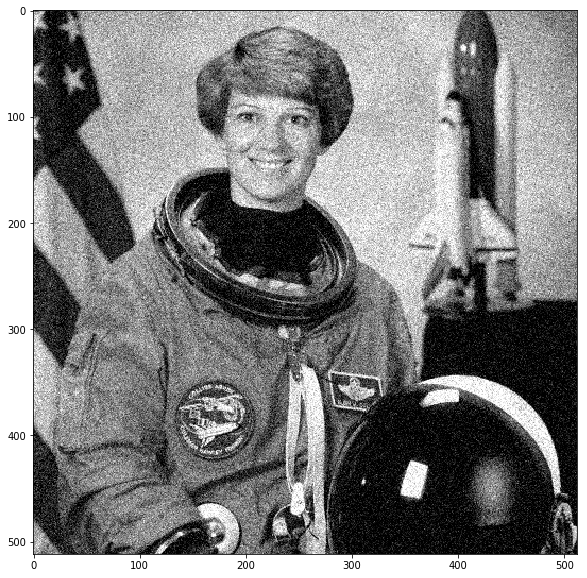

In [65]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

 ## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [69]:
from scipy.sparse.linalg import eigsh

def matrix_p2_norm(A):
    eig_val = eigsh((A.H).dot(A), return_eigenvectors=False, tol=0.001, k=1)
    return np.sqrt(eig_val).sum()

def vector_norm(x):
    return (x.T).dot(x)

def gradient_descent(x0, epsilon, lambda_, max_iterations):
    # x0: is the initial guess for the x variables
    # epsilon: is the termination tolerance parameter
    # lambda_: is the regularization parameter of the denoising problem.
    # max_iterations: is the maximum number of iterations that you allow the algorithm to run.

    # Write your code here.
    L = matrix_p2_norm(G(lamb=lambda_))
    x_updated = x0.copy()
    last_grad_norm = np.inf
    for i in range(1, max_iterations+1):
        if last_grad_norm < epsilon:
            break
        last_grad = grad_f(lamb=lambda_, x=x_updated, z_n=noisy_image)
        last_grad_norm = vector_norm(last_grad)
        x_updated = x_updated - (1.0 / L) * last_grad
    return x_updated

## Call Gradient Descent

In [ ]:
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
optimized_gd_l = gradient_descent(x0=noisy_image, 
                                  lambda_=lambda_, 
                                  epsilon=epsilon, 
                                  max_iterations=max_iterations)

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

In [ ]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5

## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [ ]:
# Write a line-search function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
def line_search(x,D,Dx,vec_image,grad_reg,grad_fit,lambda_):

# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.

# Write your code here.

# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent(x0, epsilon, lambda_, max_iterations):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.

## Call Gradient Descent with line-search

In [ ]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

In [ ]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [ ]:
# Create a line-search function
def line_search(x,D,Dx,vec_image,grad_reg,grad_fit,lambda_,gamma):

# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.

def gradient_descent(x0, epsilon, lambda_, max_iterations,gamma):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.

## Call Gradient Descent with Armijo line search

In [ ]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

In [ ]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Armijo"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10